<a href="https://colab.research.google.com/github/sdeshmukh99/Generative-AI-Showcase/blob/main/Showcase_02/OpenAI_Whisper_Model_Transcription_and_Translation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 1: Install Dependencies
This section ensures that all required libraries and packages are installed before running the code.

In [2]:
# Install necessary libraries
%%capture
!pip -q install openai  # Install OpenAI Python library to interact with the OpenAI API
!pip -q install pyannote.audio==3.1  # Install Pyannote Audio for speaker diarization
!pip -q install gradio  # Install Gradio to create a user-friendly interface for transcription/translation
!pip -q install -U git+https://github.com/openai/whisper.git  # Install Whisper model from OpenAI GitHub
!pip -q install gTTS  # Install Google Text-to-Speech library for text-to-speech conversion



### 2: Import Required Libraries
This section imports all the essential Python packages used throughout the script.

In [3]:
# Import necessary libraries for the functionality
%%capture
import os  # For operating system related functions like file management
import matplotlib.pyplot as plt  # For visualizing spectrograms
import torch  # PyTorch library for tensor computations
import torchaudio  # PyTorch library for audio processing
import whisper  # Whisper model from OpenAI for transcription and translation
import openai  # OpenAI library to interact with Whisper API
from openai import OpenAI  # To instantiate an OpenAI client for API calls
from gtts import gTTS  # Google Text-to-Speech for converting text to audio
from pyannote.audio import Pipeline  # Pyannote pipeline for speaker diarization
from pyannote.core import Segment  # For time segmentation of speakers
from pyannote.audio.pipelines.utils.hook import ProgressHook  # For progress monitoring of the diarization process
from IPython.display import Audio, clear_output  # To play audio and clear Jupyter cell output
import gradio as gr  # Gradio for building a simple UI interface



### 3: Whisper Model Setup

#### 3.1 Loading Whisper Model


In [4]:
# Load Whisper model for transcription (base model)
model = whisper.load_model("base")

# Check which device (CPU/GPU) is being used by the model for computation
model.device

100%|████████████████████████████████████████| 139M/139M [00:01<00:00, 142MiB/s]
/usr/local/lib/python3.10/dist-packages/whisper/__init__.py:150: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this exper

device(type='cpu')

#### 3.2 Test the Whisper Model with Audio

audio.mp3


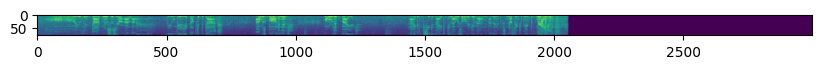

Detected language: en
Oh, you think darkness is your ally? You merely adopted the dark. I was born in it, more lived by it. I didn't see the light until I was already a man, but then it was nothing to me but bright!


In [5]:
# Download a sample audio file for testing
from IPython.display import clear_output
!wget -O audio.mp3 http://www.moviesoundclips.net/movies1/darkknightrises/darkness.mp3
clear_output()  # Clear the output to avoid clutter
!ls | grep '.mp3'  # Verify that the audio file is downloaded

# Play the downloaded audio file
audio = "audio.mp3"
Audio(audio)  # Use IPython Audio to play the file

# Process the audio file using Whisper model
audio_data = whisper.load_audio(audio)  # Load the audio data
audio_data = whisper.pad_or_trim(audio_data)  # Pad or trim the audio to fit model's input requirements

# Generate log-Mel spectrogram and move it to the same device as the model
mel = whisper.log_mel_spectrogram(audio_data).to(model.device)

# Output shape of the spectrogram
mel.shape

# Visualize the spectrogram using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(mel)
plt.show()

# Detect the spoken language in the audio
_, probs = model.detect_language(mel)
detected_language = max(probs, key=probs.get)  # Identify the most probable language
print(f"Detected language: {detected_language}")

# Decode the transcription using Whisper model (this may take time if running on CPU)
options = whisper.DecodingOptions(language='en')  # Define options for decoding (e.g., set language)
result = whisper.decode(model, mel, options)  # Perform the decoding/transcription
print(result.text)  # Output the transcribed text



### 4: Transcription and Translation Functions
This section defines the function to transcribe speech to text and translate it to the desired language using Whisper and Google Text-to-Speech.




#### 4.1 Transcription Function

In [6]:
# Dictionary mapping language names to their codes for translation and transcription
lang_mapping = {'English': 'en',
                'Spanish': 'es',
                'French': 'fr',
                'German': 'gr',
                'Italian': 'it',
                'Japanese': 'ja'}

# Function to transcribe audio and translate to the selected target language
def transcribe(audio, target_language):
    target_language = lang_mapping[target_language]  # Map the selected language to its code
    if audio is None:
        return "No audio input received.", None

    try:
        # Load and process the audio for transcription
        audio_data = whisper.load_audio(audio)
        audio_data = whisper.pad_or_trim(audio_data)

        # Generate log-Mel spectrogram and move it to the model's device
        mel = whisper.log_mel_spectrogram(audio_data).to(model.device)

        # Detect the spoken language in the audio
        _, probs = model.detect_language(mel)
        detected_language = max(probs, key=probs.get)

        # Decode the audio into text in the target language
        options = whisper.DecodingOptions(language=target_language)  # Specify target language
        result = whisper.decode(model, mel, options)

        # Convert the transcribed text to speech using Google Text-to-Speech (gTTS)
        tts = gTTS(text=result.text, lang=target_language)
        audio_output_path = "output_audio.mp3"
        tts.save(audio_output_path)  # Save the generated audio to a file

        return f"Detected language: {detected_language}\nTranscription: {result.text}", audio_output_path

    except Exception as e:
        return f"Error during transcription: {str(e)}", None  # Handle any errors that occur


#### 4.2 Testing the above Function to Transcribe Audio File in French
This subsection demonstrates downloading a sample French audio file and running the transcribe function to convert it into English text and audio.


In [7]:
# Download a sample French audio file for testing
from IPython.display import clear_output
!wget -O french.mp3 https://www.lightbulblanguages.co.uk/resources/audio/quelageastu.mp3
clear_output()
!ls | grep 'french.mp3'  # Verify that the file is downloaded

# Play the downloaded French audio
Audio('french.mp3')

# Transcribe and translate the French audio into English using the transcribe function
inp_lang, output_file_path = transcribe('french.mp3', target_language='English')
print(inp_lang)  # Print detected language and transcription

# Play the translated English audio
Audio(output_file_path)



french.mp3
Detected language: fr
Transcription: What did I do? I have 4 I have 5 I have 6 I have 7 I have 8 I have 9 I have 10 I have 11


### 5: Using Whisper through OpenAI API
This section demonstrates how to authenticate with the OpenAI API, create a client object, and use Whisper's `transcriptions` and `translations` endpoints for processing audio files.



#### 5.1 API Authentication

In [9]:
# OpenAI API Key Authentication
from google.colab import userdata

# Retrieve the API key stored as a secret in Google Colab
openai_api_key = userdata.get('OPENAI_API_KEY')

# Check if the API key is successfully retrieved
if openai_api_key is None:
    print("API key not found. Please check if it's stored correctly in Colab Secrets.")
else:
    print("API key successfully retrieved!")


API key successfully retrieved!


#### 5.2 Create OpenAI Client

In [10]:
# Import the OpenAI module and create a client object to interact with the API
from openai import OpenAI

# Instantiate an OpenAI client with the retrieved API key
client = OpenAI(api_key=openai_api_key)

# Now you can use `client` to call the Whisper model or other APIs


#### 5.3 Using Whisper for Transcription and Translation
The OpenAI Whisper API provides two key functionalities for processing audio:

1. Transcriptions: Converts audio into text in the original language.
2. Translations: Converts audio into English text (regardless of the original language).
The API accepts several audio file formats including mp3, mp4, mpeg, mpga, m4a, wav, and webm. File uploads are limited to 25 MB.

##### 5.3 A Transcribe Audio using OpenAI Whisper API
The following code demonstrates how to transcribe an audio file (in this case, "audio.mp3") into text using Whisper's `transcriptions` endpoint.

In [11]:
# Import the necessary module to play audio
from IPython.display import Audio

# Play the sample audio file to be transcribed
Audio("audio.mp3")

# Open the audio file for transcription
audio_file = open("audio.mp3", "rb")

# Transcribe the audio using Whisper's transcription model
transcription = client.audio.transcriptions.create(
  model="whisper-1",  # Specify the Whisper model to use for transcription
  file=audio_file     # Pass the audio file to the API
)

# Print the transcribed text
print(transcription.text)


Oh, you think darkness is your ally. You merely adopted the dark. I was born in it. Molded by it. I didn't see the light until I was already a man. By then it was nothing to me but blight.


##### 5.3 B Directly Return Transcribed Text
If you only need the text output and want to bypass other metadata, you can request the transcribed text directly in plain text format.

In [12]:
# Directly request the transcribed text (in plain text format)
transcription_text = client.audio.transcriptions.create(
  model="whisper-1",    # Use Whisper model
  file=audio_file,      # Pass the audio file
  response_format="text"  # Request the response in text format only
)

# Print the directly returned transcription text
print(transcription_text)


Oh, you think darkness is your ally. You merely adopted the dark. I was born in it. Molded by it. I didn't see the light until I was already a man. By then it was nothing to me but blight.



#### 5.4 Translate Audio Using Whisper API
The Whisper API can also translate non-English audio into English. In the following example, we download a sample French audio file and use the translations endpoint to translate it into English text.

##### 5.4 A Download a Sample French Audio File


In [13]:
# Download a sample French audio file for translation
from IPython.display import clear_output
!wget -O french.mp3 https://www.lightbulblanguages.co.uk/resources/audio/quelageastu.mp3
clear_output()  # Clear output for a cleaner view
!ls | grep 'french.mp3'  # Verify that the file was downloaded


french.mp3


##### 5.4 B Translate Audio Using Whisper API


In [14]:
# Play the downloaded French audio file
Audio("french.mp3")

# Open the French audio file for translation
audio_file = open("french.mp3", "rb")

# Translate the French audio into English using Whisper's translation model
translation = client.audio.translations.create(
  model="whisper-1",     # Use Whisper model for translation
  file=audio_file,       # Pass the French audio file
  prompt='Translate to English'  # Request translation to English
)

# Print the translated text in English
print(translation.text)


Quel âge as-tu? J'ai quatre ans. J'ai cinq ans. J'ai six ans. J'ai sept ans. J'ai huit ans. J'ai neuf ans. J'ai dix ans. J'ai onze ans.


### 6: Text-to-Speech Example
This section uses the `TTS (text-to-speech)` model from OpenAI, specifically designed to generate speech from a given input text. The API handles the conversion of the text into audio using pre-trained models, such as the `tts-1` model.


In [15]:
# Text to convert into speech
input_text = "This showcase is written by Shantanu Deshmukh!"

# File path to save the generated speech
save_speech_file_path = "speech.mp3"

# Use OpenAI API to generate speech from the text
response = client.audio.speech.create(
    model="tts-1",      # Use the TTS model from OpenAI
    voice="alloy",      # Select the voice for speech output
    input=input_text    # The text to be converted into speech
)

# Save the generated speech audio to a file
response.write_to_file(save_speech_file_path)

# Play the generated speech audio
Audio(save_speech_file_path)


### 7: Any-Audio to English-Audio Translation
This section addresses a more complex task of translating non-English audio into English and converting that translated text into English speech.

This section first leverages the `Whisper` model from OpenAI for audio-to-text translation (non-English audio into English text), and then uses the `TTS model` to convert the resulting English text into speech. This section showcases the use of both translation (via `Whisper`) and text-to-speech (via `TTS`) models.


In [16]:
# Function to convert non-English audio to English speech
def convert_to_eng_audio(input_file_path, save_path="generated_audio.mp3"):

    # Step 1: Read the input audio file
    audio_file = open(input_file_path, "rb")

    # Step 2: Translate the audio to English using Whisper model via OpenAI API
    translation = client.audio.translations.create(
        model="whisper-1",        # Use Whisper model for translation
        file=audio_file,          # Provide the audio file
        prompt='Translate to English'  # Request translation to English
    )
    input_text = translation.text  # Extract the translated text

    # Step 3: Convert the translated text into speech using Text-to-Speech
    response = client.audio.speech.create(
        model="tts-1",            # Use the Text-to-Speech model
        voice="alloy",            # Specify the voice for audio output
        input=input_text          # Use the translated text as input
    )

    # Step 4: Save the generated speech audio
    response.write_to_file(save_path)
    print(f"Response saved in: {save_path}")

    # Return the saved audio file path
    return Audio(save_path)


### 9: Capturing User Audio
This section is focused on recording audio directly from the user in real-time. It doesn’t involve translation or text-to-speech directly, but it provides an audio input that can then be passed to the translation and TTS process in section 8 above.

#### 9.1: Record Audio from the User
This block allows the user to record audio directly in the Colab environment using JavaScript and Python integration.

In [19]:
import os
from datetime import datetime
from IPython.display import Javascript
from google.colab import output
from base64 import b64decode
import IPython.display as ipd
from IPython.display import Audio

# JavaScript code to capture audio from the user in real-time
RECORD = """
const sleep  = time => new Promise(resolve => setTimeout(resolve, time))
const b2text = blob => new Promise(resolve => {
  const reader = new FileReader()
  reader.onloadend = e => resolve(e.srcElement.result)
  reader.readAsDataURL(blob)
})
var record = time => new Promise(async resolve => {
  stream = await navigator.mediaDevices.getUserMedia({ audio: true })
  recorder = new MediaRecorder(stream)
  chunks = []
  recorder.ondataavailable = e => chunks.push(e.data)
  recorder.start()
  await sleep(time)
  recorder.onstop = async ()=>{
    blob = new Blob(chunks)
    text = await b2text(blob)
    resolve(text)
  }
  recorder.stop()
})
"""

# Create a directory to store recorded audio if it doesn't exist
if not os.path.exists('MyAudios/'):
    os.mkdir("MyAudios")

# Function to record audio for a specified number of seconds (default: 10 seconds)
def record(sec=10):
    print("Start speaking! (10 sec left)")
    now = datetime.now()
    current_time = now.strftime("%Y-%m-%d_%H-%M-%S")

    # Display the JavaScript recorder interface
    display(Javascript(RECORD))
    s = output.eval_js('record(%d)' % (sec*1000))

    # Decode the base64-encoded audio
    b = b64decode(s.split(',')[1])

    # Save the recorded audio to the MyAudios directory
    with open('MyAudios/audio_'+current_time+'.mp3', 'wb') as f:
        f.write(b)

    # Return the file path of the saved audio
    print('input_file_path = MyAudios/audio_'+current_time+'.mp3')
    return 'MyAudios/audio_'+current_time+'.mp3'

# Call the record function to capture audio (default: 10 seconds)
input_file_path = record()

# Play the recorded audio
Audio(input_file_path)


Start speaking! (10 sec left)


<IPython.core.display.Javascript object>

input_file_path = MyAudios/audio_2024-10-08_09-54-56.mp3


#### 9.2: Convert Recorded Audio to English Speech
This section takes the user-recorded audio and translates it to English using the earlier function.



In [20]:
# Convert the recorded audio to English speech using the convert_to_eng_audio function
convert_to_eng_audio(input_file_path)


Response saved in: generated_audio.mp3


### 10: Audio Capture and Speaker Diarization
This section includes code to capture user audio and perform speaker diarization using pyannote.audio.

#### 10.1 Pre-requisites for Using the Diarization Pipeline
Here, we will be using `pyannote/speaker-diarization-3.1` pipeline to extract different speakers from a conversation audio.

Pre-requisite steps to use this pipeline are:

- Install pyannote.audio 3.1 with `pip install pyannote.audio==3.1`. This is installed at the start.
- Visit https://huggingface.co/pyannote/segmentation-3.0 and accept user conditions
- Visit https://huggingface.co/pyannote/speaker-diarization-3.1 and accept user conditions
- Visit https://huggingface.co/settings/tokens to create an access token
- Instantiate pretrained speaker diarization pipeline


#### 10.2 Download a Sample Conversation Audio

In [21]:
from IPython.display import clear_output
!wget -O conversation.mp3 https://www.moviesoundclips.net/movies1/overthehedge/chip.mp3
clear_output()  # Clears the cell output for cleanliness
!ls | grep 'conversation.mp3'  # List the downloaded file to verify

conversation.mp3


#### 10.3 Play the Conversation Audio


In [22]:
# Play the downloaded audio file
Audio("conversation.mp3")

#### 10.4 Transcribing the Audio Using Whisper API


In [23]:
# Read the audio file into a variable
file_name = "conversation.mp3"
audio_file = open(file_name, "rb")

# Use OpenAI Whisper API to transcribe the conversation audio
result = client.audio.transcriptions.create(
  model="whisper-1",  # Specify the model to use for transcription
  file=audio_file     # Pass the audio file to be transcribed
)

# Extract the transcription text
conversation_text = result.text
conversation_text  # Output the transcribed conversation text


'What is that? That, my friend, is a magical combination of corn flour, dehydrated cheese solids, BHA, BHT, and good old MSG. A.K.A. the chip. Nacho cheese flavor.'

#### 10.5 Load the Diarization Pipeline


In [24]:
from pyannote.audio import Pipeline

# Load Hugging Face token for authentication from Colab Secrets
os.environ['HF_TOKEN'] = userdata.get('HF_TOKEN')

# Instantiate the Pyannote Speaker Diarization pipeline using the access token
diarization_pipeline = Pipeline.from_pretrained("pyannote/speaker-diarization@2.1", use_auth_token=os.environ['HF_TOKEN'])


config.yaml:   0%|          | 0.00/500 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/17.7M [00:00<?, ?B/s]

config.yaml:   0%|          | 0.00/318 [00:00<?, ?B/s]

INFO:pytorch_lightning.utilities.migration.utils:Lightning automatically upgraded your loaded checkpoint from v1.5.4 to v2.4.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../root/.cache/torch/pyannote/models--pyannote--segmentation/snapshots/c4c8ceafcbb3a7a280c2d357aee9fbc9b0be7f9b/pytorch_model.bin`


Model was trained with pyannote.audio 0.0.1, yours is 3.1.0. Bad things might happen unless you revert pyannote.audio to 0.x.
Model was trained with torch 1.10.0+cu102, yours is 2.4.1+cu121. Bad things might happen unless you revert torch to 1.x.


hyperparams.yaml:   0%|          | 0.00/1.92k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/speechbrain/utils/autocast.py:68: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  wrapped_fwd = torch.cuda.amp.custom_fwd(fwd, cast_inputs=cast_inputs)


embedding_model.ckpt:   0%|          | 0.00/83.3M [00:00<?, ?B/s]

mean_var_norm_emb.ckpt:   0%|          | 0.00/1.92k [00:00<?, ?B/s]

classifier.ckpt:   0%|          | 0.00/5.53M [00:00<?, ?B/s]

label_encoder.txt:   0%|          | 0.00/129k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/speechbrain/utils/checkpoints.py:194: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(path, map_location=device

#### 10.6 Run the Speaker Diarization Pipeline


In [25]:
# Run the diarization pipeline on the conversation audio file to separate speakers
# Hooks are available to monitor the progress of the pipeline
from pyannote.audio.pipelines.utils.hook import ProgressHook

# Perform diarization and extract speakers
with ProgressHook() as hook:
    diarization = diarization_pipeline('conversation.mp3', num_speakers=2, hook=hook)


Output()

#### 10.7 Visualize the Diarization Result


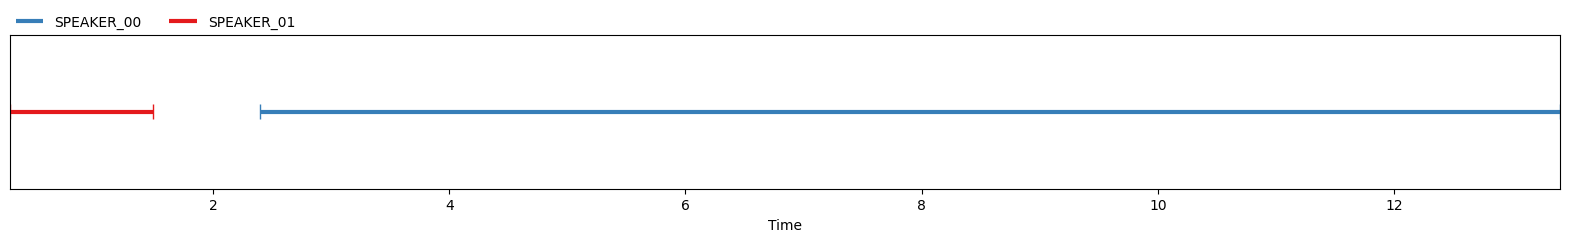

In [26]:
# Display the diarization result
diarization

#### 10.8 Get Timeframes for All Speakers


In [27]:
# Initialize lists to store speaker labels and their corresponding timeframes
speakers = []
speakers_start = []
speakers_stop = []

# Iterate over the diarization result to extract timeframes for each speaker
for turn, track, speaker in diarization.itertracks(yield_label=True):
    speakers.append(speaker)
    speakers_start.append(turn.start)
    speakers_stop.append(turn.end)
    # Print the speaker's timeframes
    print(f"{speaker} : Start={turn.start:.1f}s Stop={turn.end:.1f}s")


SPEAKER_01 : Start=0.3s Stop=1.5s
SPEAKER_00 : Start=2.4s Stop=13.4s


#### 10.9 Transcribe Audio for Each Speaker


In [29]:
# Import the 'Audio' class from the 'pyannote.audio' library, which is
# used for audio processing tasks such as loading, cropping, and manipulating audio files.
from pyannote.audio import Audio

# Initialize an empty list to store the transcription of each speaker's segment
speakers_text = []

# Load the audio data for processing using pyannote
py_audio = Audio(mono="downmix")

# Loop through each speaker's segment and transcribe the audio for that speaker
for i in range(len(speakers)):
    # Define the segment (timeframe) for the current speaker
    segment = Segment(speakers_start[i], speakers_stop[i])

    # Extract the audio for this segment (speaker)
    waveform, sr = py_audio.crop("conversation.mp3", segment)

    # Save the speaker's audio as a separate file
    torchaudio.save("speaker"+str(i)+".mp3", waveform, sr)

    # Open the saved audio file for transcription
    audio_file = open("speaker"+str(i)+".mp3", "rb")

    # Use Whisper API to transcribe the audio for this speaker
    speaker_test = client.audio.translations.create(
        model="whisper-1",  # Specify the model for transcription
        file=audio_file     # Provide the speaker's audio file
    )

    # Append the transcription text to the list
    speakers_text.append(speaker_test.text)


#### 10.11 Display Speaker Labels, Timeframes, and Transcribed Text


In [30]:
# Print a formatted table displaying the speakers, their start/stop times, and the transcribed text
print(f"{'Speaker':<12} {'Start(sec)':<12} {'Stop(sec)':<12} {'Text'}")
print('='*60)

# Iterate through the speakers and their respective data
for i in range(len(speakers)):
    # Print speaker details along with their transcribed text
    print(f"{speakers[i]:<12} {round(speakers_start[i],2):<12} {round(speakers_stop[i],2):<12} {speakers_text[i]}")


Speaker      Start(sec)   Stop(sec)    Text
SPEAKER_01   0.28         1.49         What is that?
SPEAKER_00   2.4          13.4         That, my friend, is a magical combination of cornflour, dehydrated cheese solids, BHA, BHT, and good old MSG. A.K.A. the chips. Nacho cheese flavor.


### 11. Gradio Interface for Transcription and Translation
This section sets up a simple Gradio interface for users to upload audio files and select a language for translation.

In [32]:
import gradio as gr

# Input elements
audio_input = gr.Audio(type="filepath", label="Record or Upload Audio for Transcription")
target_lang = gr.Dropdown(choices=["English", "Spanish", "French", "German", "Italian", "Japanese"], label="Target Language")

# Output elements
transcription_output = gr.Textbox(label="Transcription Output")
audio_output = gr.Audio(label="Translated Speech Output")

# Interface
demo = gr.Interface(
    fn=transcribe,
    inputs=[audio_input, target_lang],
    outputs=[transcription_output, audio_output],
    title="Whisper Audio Transcription and Translation",
    description="Created by Shantanu Deshmukh",
    allow_flagging='never',
)

# Launch Gradio app
demo.launch(debug=False, share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://7ac5bdc79cc39e4990.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
